In [1]:
import sys
sys.path.append('..')
from CANN_DDM_models import generate_evidence_variable, CANN_DDM_bump_edge_model, run_CANN_simulation
from matplotlib import pyplot as plt
from scipy import stats
import numpy as np
from tqdm import tqdm
from brainpy import math as bm

In [2]:
def calculate_edge_velocity(c1_all, num_seeds=10, DDM_params=None, CANN_params=None):
    """Calculate edge velocity for different c1 values.
    
    Parameters:
    -----------
    c1_all : array-like
        Array of c1 values to test
    num_seeds : int, optional
        Number of random seeds to use per c1 value
    DDM_params : dict, optional
        Parameters for the DDM model
    CANN_params : dict, optional
        Parameters for the CANN model
    """
    # Default parameters
    default_DDM_params = {
        'dt': 1.,
        'dt_DDM': 10.,
        'v': .5,
        'sig_W': .8,
        'boundary': .8
    }

    default_CANN_params = {
        'dur1': 500,
        'dur2': 1000,
        'num': 1024,
        'tau_bump': 0.1,
        'tau_edge': 1,
        'beta': 2,
        'offset': 3.85,
        'delta_z': 1/40,
        'J0_bump': 1,
        'J0_edge': 1,
        'a': 0.25,
        'A': 10,
        'c2': 1,
        'edge_type': 'tanh'
    }

    # Update with provided parameters
    DDM_params = {**default_DDM_params, **(DDM_params or {})}
    CANN_params = {**default_CANN_params, **(CANN_params or {})}

    # Extract parameters
    dt = DDM_params['dt']
    dt_DDM = DDM_params['dt_DDM']
    v = DDM_params['v']
    sig_W = DDM_params['sig_W']
    boundary = DDM_params['boundary']

    dur1 = CANN_params['dur1']
    dur2 = CANN_params['dur2']
    num = CANN_params['num']
    tau_bump = CANN_params['tau_bump']
    tau_edge = CANN_params['tau_edge']
    beta = CANN_params['beta']
    offset = CANN_params['offset']
    delta_z = CANN_params['delta_z']
    J0_bump = CANN_params['J0_bump']
    J0_edge = CANN_params['J0_edge']
    a = CANN_params['a']
    A = CANN_params['A']
    c2 = CANN_params['c2']
    edge_type = CANN_params['edge_type']

    t_prep = (dur1 + 0.1 * dur2)
    v_edge = []
    
    for c1 in tqdm(c1_all):
        v_edge_per_c1 = []
        for i in range(num_seeds):
            seed = 2025 + i
            clicks_left, clicks_right, _, _ = generate_evidence_variable(v, sig_W, dur1, dur2, dt_DDM, dt=dt, seed=seed)
            
            my_model = CANN_DDM_bump_edge_model(num=num, c1=c1, c2=c2, J0_bump=J0_bump,
                                                tau_bump=tau_bump,
                                                J0_edge=J0_edge, edge_offset=offset,
                                                optimize_offset=False,
                                                t_prep=t_prep, a=a, A=A,
                                                beta=beta, edge_type=edge_type, delta_z=delta_z, seed=seed)
            
            mon_vars = ['u_pos', 'u_dpos', 'RT']
            runner = run_CANN_simulation(my_model, clicks_left, clicks_right, dur1, dur2, mon_vars, dt=dt, progress_bar=False)
            RT = runner.mon.RT[-1]
            if RT < dur1 + dur2 - t_prep:
                v = bm.mean(bm.abs(runner.mon.u_dpos[int(t_prep):int(t_prep+RT)])) / dt * 1e3
            else:
                v = bm.mean(bm.abs(runner.mon.u_dpos[int(t_prep):])) / dt * 1e3
            v_edge_per_c1.append(v)
            
            
            # Clean up
            del my_model, runner, clicks_left, clicks_right
            
        v_edge.append(np.array(v_edge_per_c1))
    return  np.array(v_edge)

In [7]:
# Set the style for scientific plotting
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.format': 'pdf',
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1,
    'axes.linewidth': 1.5,
    'axes.spines.top': False,
    'axes.spines.right': False,
})

# Define colors (using Nature-style color palette)
colors = {
    'scatter': '#E64B35',  # Nature red
    'error': '#4DBBD5',    # Nature blue
    'theory': '#3C5488',   # Nature dark blue
    'fit': '#FF0000',      # Red for fit line
    'grid': '#E0E0E0'      # Light gray for grid
}
DDM_params = {
        'dt': 1.,
        'dt_DDM': 25.,
        'v': .5,
        'sig_W': .5,
        'boundary': .8}
CANN_params = {
        'dur1': 500,
        'dur2': 3000,
        'num': 1024,
        'tau_bump': 0.1,
        'tau_edge': 1.5,
        'beta': 2,
        'offset': 3.85,
        'delta_z': 1/40,
        'J0_bump': 4,
        'J0_edge': 1,
        'a': 0.25,
        'A': 10,
        'c2': .5,
        'edge_type': 'tanh'
    }

c1_all = np.linspace(0.5, 4, 20)
#c1_all = np.linspace(1, 1.5, 10)
num_seeds = 10
beta = CANN_params['beta']
bump_height = 0.53

# Calculate edge velocities
v_edge = calculate_edge_velocity(c1_all, num_seeds=num_seeds, CANN_params=CANN_params, DDM_params=DDM_params) 

100%|██████████| 20/20 [02:49<00:00,  8.46s/it]


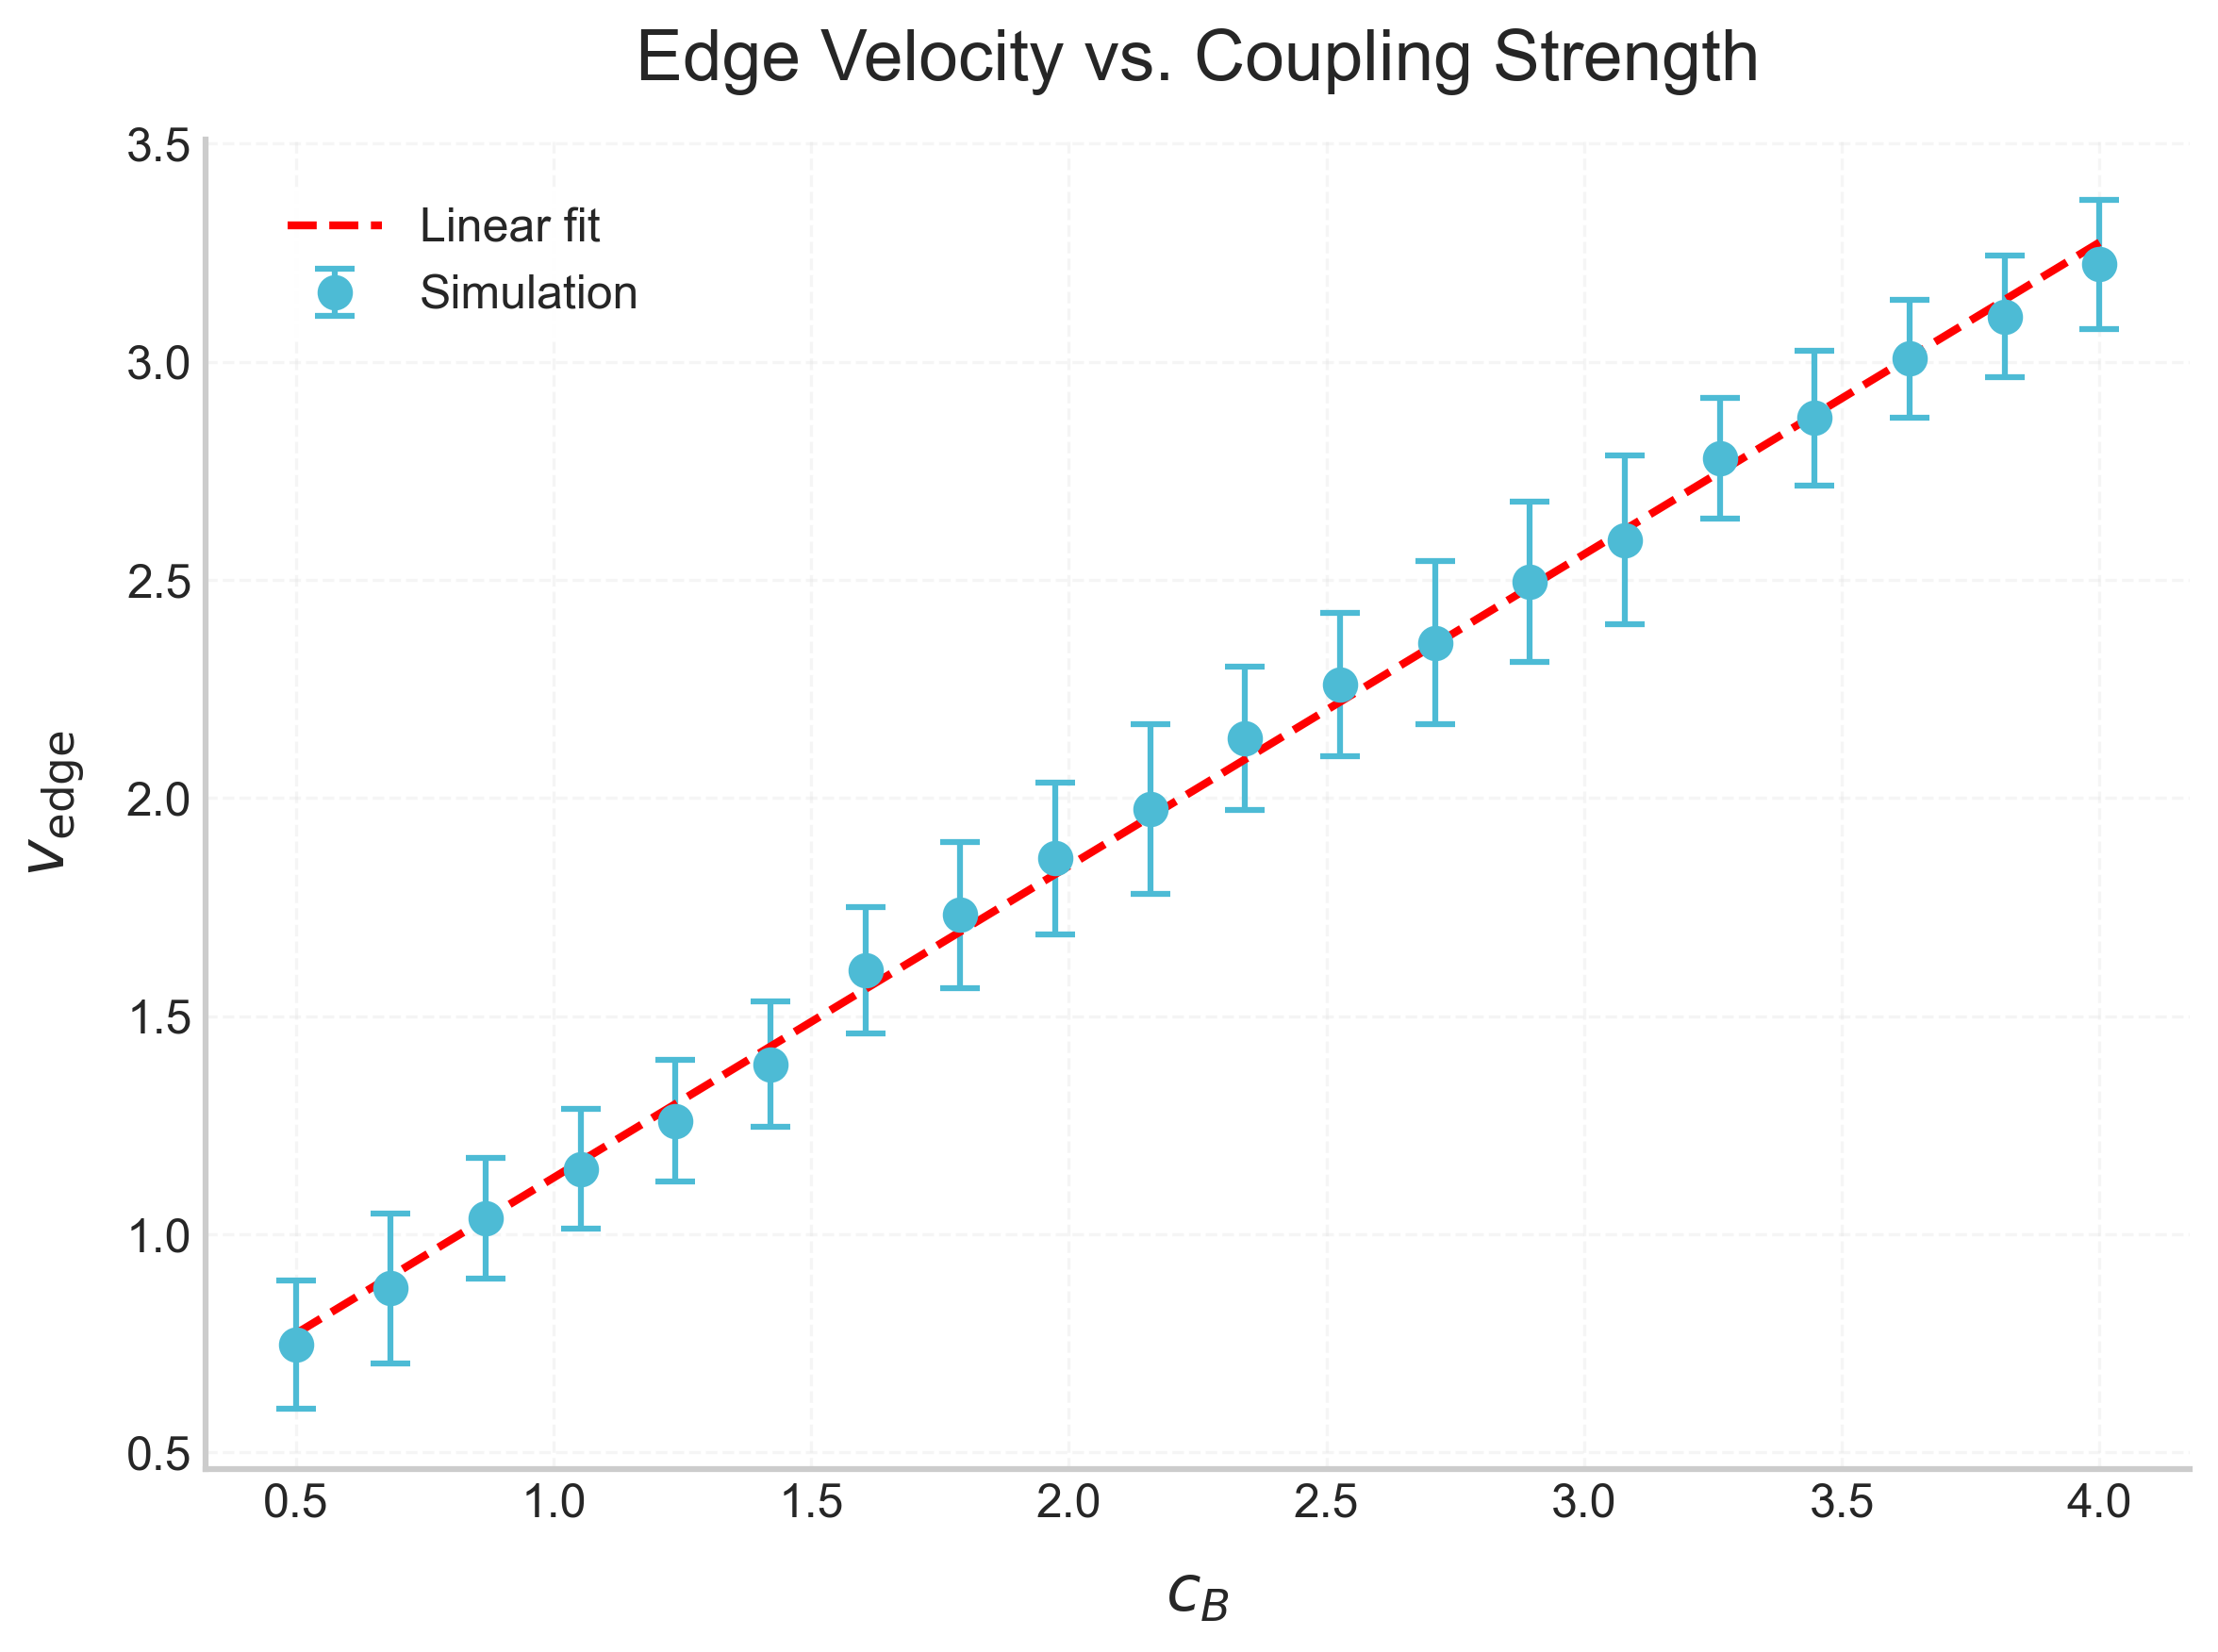

In [9]:


# Create figure with specific size and DPI
fig, ax = plt.subplots(figsize=(8, 6), dpi=300)

# Plot scatter points with enhanced styling
# for i, c1 in enumerate(c1_all):
#     y_vals = v_edge[i]
#     x_vals = [c1] * len(y_vals)
#     ax.scatter(x_vals, y_vals, 
#               alpha=0.6, 
#               marker='o',  
#               color=colors['scatter'],
#               s=40,       
#               label='Simulation' if i == 0 else None)

# Plot mean and std with enhanced error bars
means = np.mean(v_edge, axis=1)
stds = np.std(v_edge, axis=1)
ax.errorbar(c1_all, means, yerr=stds, 
           fmt='o', 
           color=colors['error'],
           capsize=5,
           capthick=1.5,
           elinewidth=1.5,
           markersize=8,
           label='Simulation')

# Linear regression fit
slope, intercept = np.polyfit(c1_all, means, 1)
fit_line = slope * c1_all + intercept
ax.plot(c1_all, fit_line, 
        color=colors['fit'], 
        linestyle='--', 
        linewidth=2,
        label=f'Linear fit',
        zorder=2)

# Plot theoretical prediction with enhanced line style
#v_pred = lambda sigma, c1, bump_height: c1 / sigma * bump_height
# ax.plot(c1_all, [v_pred(0.5/beta, c1, 0.57) for c1 in c1_all],
#         color=colors['theory'],
#         linestyle='--', 
#         linewidth=2,
#         label='Theoretical prediction',
#         zorder=3)  

# Customize axes
ax.set_xlabel(r'$c_B$', fontsize=16, labelpad=10)
ax.set_ylabel(r'$v_{\text{edge}}$', fontsize=16, labelpad=10)
ax.set_title(r'Edge Velocity vs. Coupling Strength', fontsize=18, pad=15)

# Customize grid
ax.grid(True, linestyle='--', alpha=0.3, color=colors['grid'])

# Customize legend
ax.legend(frameon=True, 
         loc='upper left',
         bbox_to_anchor=(0.02, 0.98),
         framealpha=0.95,
         edgecolor='none')

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig('edge_velocity_plot.pdf', bbox_inches='tight', dpi=300)
plt.show()